In [ ]:
# Imports and basic set up:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

from sklearn.cluster import KMeans

In [ ]:
#2.2: Data Wrangling and Cleaning

#df_raw = pd.read_csv("Food_Establishment_Inspection_Data_20251114.csv")
df_raw = pd.read_csv("Food_Establishment_Inspection_Data_20251119.csv",
                 on_bad_lines="skip")
#df_raw = pd.read_csv('/content/Food_Establishment_Inspection_Data_20251119.csv')


#LOAD RAW DATA
#df_raw = pd.read_csv("Food_Establishment_Inspection_Data_20251114.csv",
                     #low_memory=False)

# BASIC TYPE CONVERSIONS
df = df_raw.copy()

# Dates
df["Inspection Date"] = pd.to_datetime(df["Inspection Date"], errors="coerce")

# Numeric columns
for col in ["Inspection Score", "Violation Points", "Grade",
            "Longitude", "Latitude"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# HANDLE MISSING VIOLATION INFO
# NaN in violation fields usually means "no violation cited" → keep, but mark explicitly

df["Violation Type"] = df["Violation Type"].fillna("None")
df["Violation Description"] = df["Violation Description"].fillna("None")
df["Violation_Record_ID"] = df["Violation_Record_ID"].fillna("None")

# If Violation Points were ever missing, treat them as 0 (no points)
df["Violation Points"] = df["Violation Points"].fillna(0)

# Binary flag: whether this *row* is a red violation
df["is_red_violation"] = df["Violation Type"].str.upper().eq("RED")

# RISK CATEGORY FROM DESCRIPTION
# Example: "Seating 0-12 - Risk Category III"
df["Risk_Category"] = (
    df["Description"]
      .astype(str)
      .str.extract(r"Risk\s*Category\s*([IVX]+)", expand=False)
      .fillna("Unknown")
)

# HANDLE OTHER MISSING VALUES
# Grade: missing usually means no grade issued → use sentinel value
df["Grade"] = df["Grade"].fillna(-1)

# We’ll drop rows that are missing *core identifiers*
df = df.dropna(subset=["Business_ID", "Inspection Date"])

# DROP COLUMNS WE WON'T USE FOR MODELING
df = df.drop(columns=[
    "Phone",
    "Address",
    "City",
    "Zip Code",
    "Program Identifier",
    "Inspection Business Name"
], errors="ignore")

# BUILD INSPECTION-LEVEL DATA
# One row per inspection (multiple violation rows → aggregated)
agg_funcs = {
    "Name": "first",
    "Description": "first",
    "Inspection Type": "first",
    "Inspection Score": "max",
    "Inspection Result": "first",
    "Inspection Closed Business": "first",
    "Violation Points": "sum",          # total points across violations
    "is_red_violation": "max",          # did this inspection have ≥1 red violation?
    "Grade": "max",
    "Longitude": "first",
    "Latitude": "first",
    "Risk_Category": "first"
}

df_inspections = (
    df.groupby(
        ["Business_ID", "Inspection_Serial_Num", "Inspection Date"],
        dropna=False,
        as_index=False
    ).agg(agg_funcs)
)

# Rename convenience columns
df_inspections = df_inspections.rename(columns={
    "is_red_violation": "has_red_violation"
})


# Sort for later sequential feature engineering
df_inspections = df_inspections.sort_values(
    ["Business_ID", "Inspection Date"]
).reset_index(drop=True)

# Create Restaurant_Type ONCE from Description
df_inspections["Restaurant_Type"] = (
    df_inspections["Description"]
    .astype(str)
    .str.extract(r"^([^–-]+)", expand=False)  # text before first dash
    .str.strip()
    .fillna("Unknown")
)

# Clean up categories so "Non" disappears

# Any type starting with "Non" → Non-Seating
df_inspections["Restaurant_Type"] = df_inspections["Restaurant_Type"].str.replace(
    r"^Non\b.*", "Non-Seating", regex=True
)

# Any type starting with "School Lunch Program" → School
df_inspections["Restaurant_Type"] = df_inspections["Restaurant_Type"].str.replace(
    r"^School Lunch Program.*", "School", regex=True
)

# Any type starting with "Seating" → Restaurant (Seating)
df_inspections["Restaurant_Type"] = df_inspections["Restaurant_Type"].str.replace(
    r"^Seating.*", "Restaurant (Seating)", regex=True
)

df_inspections["Restaurant_Type"] = df_inspections["Restaurant_Type"].str.strip()

# Collapse inspection result into two categories
df_inspections["Result_Simple"] = np.where(
    df_inspections["Inspection Result"]
    .str.contains("satisf", case=False, na=False),
    "Satisfactory",
    "Unsatisfactory/Other"
)

print(df_inspections.head())
print(df_inspections.isna().mean().sort_values(ascending=False).head(15))


/tmp/ipython-input-2684017460.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("Food_Establishment_Inspection_Data_20251119.csv",


  Business_ID Inspection_Serial_Num Inspection Date               Name  \
0   PR0001008             DA1596254      2006-10-09  OLD FIFTH AVE LLC   
1   PR0001008             DA1630313      2006-12-28  OLD FIFTH AVE LLC   
2   PR0001008             DA1655203      2007-03-01  OLD FIFTH AVE LLC   
3   PR0001008             DA1714269      2007-07-12  OLD FIFTH AVE LLC   
4   PR0001008             DA1785000      2007-12-19  OLD FIFTH AVE LLC   

                         Description                  Inspection Type  \
0  Seating 13-50 - Risk Category III   Consultation/Education - Field   
1  Seating 13-50 - Risk Category III  Routine Inspection/Field Review   
2  Seating 13-50 - Risk Category III   Consultation/Education - Field   
3  Seating 13-50 - Risk Category III  Routine Inspection/Field Review   
4  Seating 13-50 - Risk Category III  Routine Inspection/Field Review   

   Inspection Score Inspection Result Inspection Closed Business  \
0               0.0          Complete           

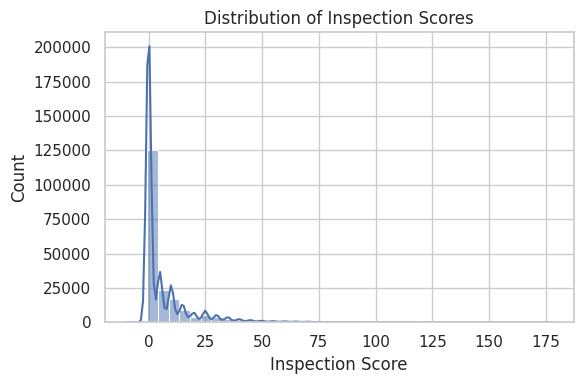

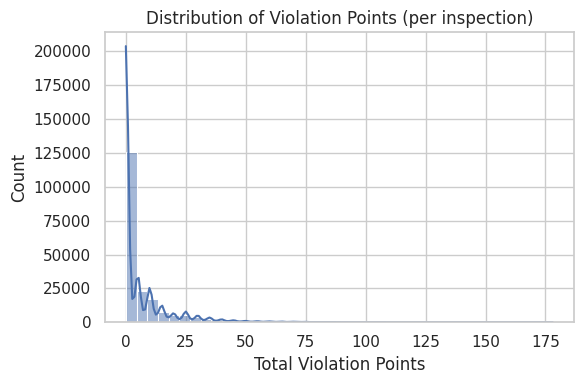

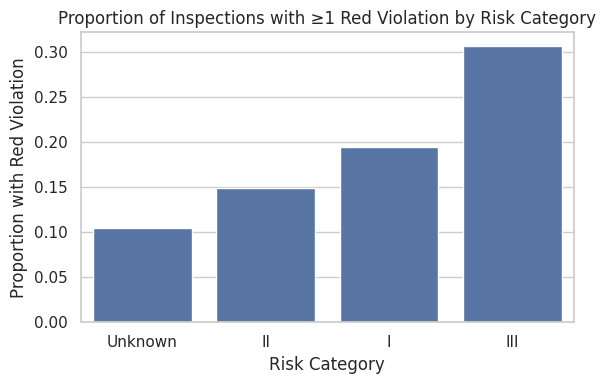

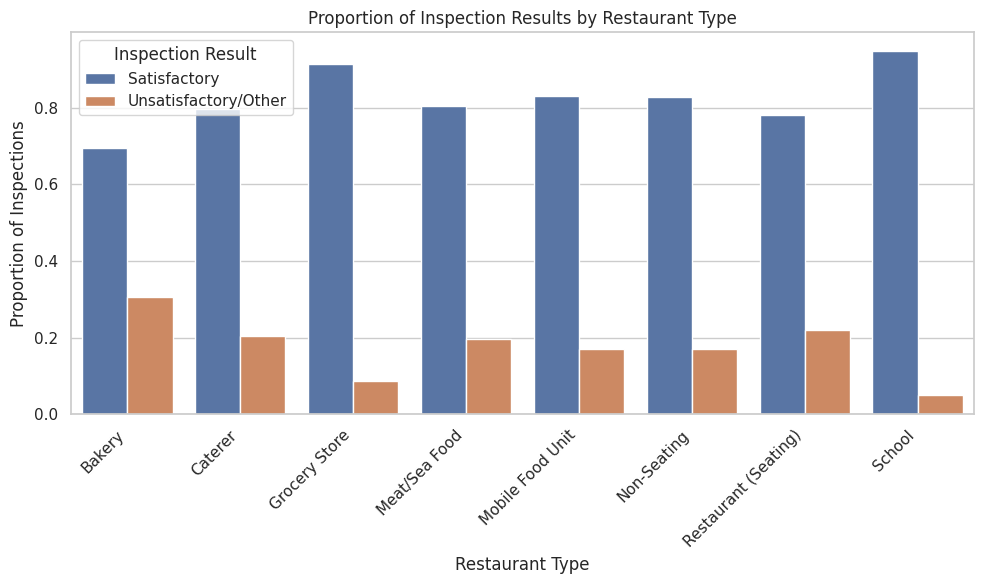

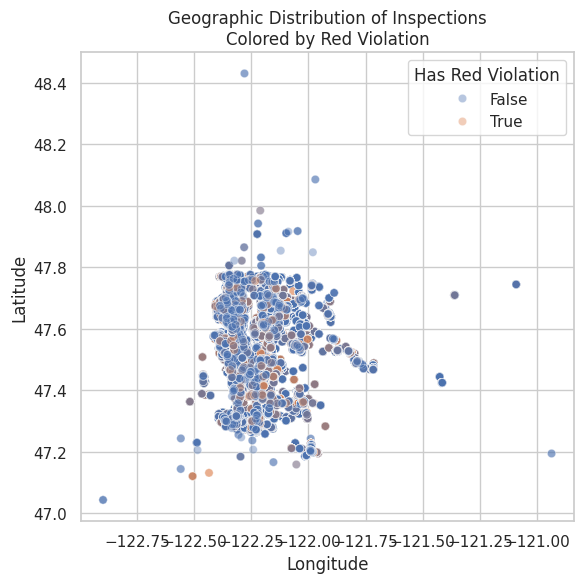

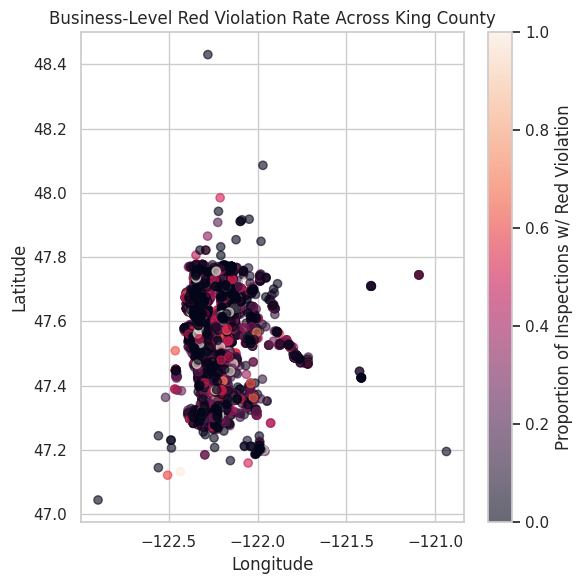

In [ ]:
#2.3: Exploratory Data Analysis and Visualization

sns.set(style="whitegrid")

# ==========================
# Distribution: Inspection Scores
# ==========================
plt.figure(figsize=(6,4))
sns.histplot(df_inspections["Inspection Score"], bins=40, kde=True)
plt.title("Distribution of Inspection Scores")
plt.xlabel("Inspection Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ==========================
# Distribution: Violation Points
# ==========================
plt.figure(figsize=(6,4))
sns.histplot(df_inspections["Violation Points"], bins=40, kde=True)
plt.title("Distribution of Violation Points (per inspection)")
plt.xlabel("Total Violation Points")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ==========================
# Risk Category vs Proportion with Red Violation
#   (sorted low → high)
# ==========================
risk_red = (
    df_inspections
    .groupby("Risk_Category")["has_red_violation"]
    .mean()
    .reset_index()
    .sort_values("has_red_violation")
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=risk_red,
    x="Risk_Category",
    y="has_red_violation",
    order=risk_red["Risk_Category"]
)
plt.title("Proportion of Inspections with ≥1 Red Violation by Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Proportion with Red Violation")
plt.tight_layout()
plt.show()

# ================================================
#Inspection Result proportions by Restaurant Type
# ================================================


# Compute proportions by restaurant type
result_by_type = (
    df_inspections
    .groupby(["Restaurant_Type", "Result_Simple"])
    .size()
    .reset_index(name="count")
)

result_by_type["prop"] = (
    result_by_type["count"] /
    result_by_type.groupby("Restaurant_Type")["count"].transform("sum")
)

# Only show top 8 types for a clean plot
top_types = (
    df_inspections["Restaurant_Type"]
    .value_counts()
    .head(8)
    .index
)

result_top = result_by_type[result_by_type["Restaurant_Type"].isin(top_types)]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=result_top,
    x="Restaurant_Type",
    y="prop",
    hue="Result_Simple"
)
plt.xticks(rotation=45, ha="right")
plt.title("Proportion of Inspection Results by Restaurant Type")
plt.xlabel("Restaurant Type")
plt.ylabel("Proportion of Inspections")
plt.legend(title="Inspection Result")
plt.tight_layout()
plt.show()

# ==========================
# Geographic Scatter (all inspections)
# ==========================
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_inspections,
    x="Longitude",
    y="Latitude",
    hue="has_red_violation",
    alpha=0.4
)
plt.title("Geographic Distribution of Inspections\nColored by Red Violation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Has Red Violation")
plt.tight_layout()
plt.show()

# ==========================
# Geographic — business-level violation rate
# ==========================
business_red = (
    df_inspections
    .groupby(["Business_ID", "Longitude", "Latitude"])["has_red_violation"]
    .mean()
    .reset_index()
    .rename(columns={"has_red_violation": "prop_red"})
)

plt.figure(figsize=(6,6))
scatter = plt.scatter(
    business_red["Longitude"],
    business_red["Latitude"],
    c=business_red["prop_red"],
    alpha=0.6
)
plt.colorbar(scatter, label="Proportion of Inspections w/ Red Violation")
plt.title("Business-Level Red Violation Rate Across King County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()



In [ ]:

# Load and prepare data

df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
df = df.sort_values(['Name', 'Inspection Date'])


# Construct target variable: Next Red Violation

df['red_violation'] = df['Violation Type'].str.contains('red', case=False, na=False).astype(int)

# For each restaurant, shift the red_violation column to align "next inspection"
df['next_red_violation'] = df.groupby('Name')['red_violation'].shift(-1)

# Drop rows where next inspection doesn’t exist (last inspection per restaurant)
df = df.dropna(subset=['next_red_violation'])
df['next_red_violation'] = df['next_red_violation'].astype(int)


In [ ]:
# 2.4: Feature Engineering

features = df.groupby('Name').apply(
    lambda x: pd.Series({
        'avg_past_score': x['Inspection Score'].mean(),
        'num_prev_inspections': x['Inspection Date'].nunique(),
        'prop_red_violations': x['red_violation'].mean(),
        'avg_violation_points': x['Violation Points'].mean(),
        'time_since_last_insp': (x['Inspection Date'].max() - x['Inspection Date'].min()).days,
        # Target: whether next inspection had red violation
        'Next Red Violation': x['next_red_violation'].max()  # max works since it's binary
    })
).reset_index()



# Features + target
X = features.drop(columns=['Name', 'Next Red Violation'])
y = features['Next Red Violation']

# Handle any NaNs (use means instead of 0 so scaling behaves better)
X = X.fillna(X.mean())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Scale features for models sensitive to magnitude
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/tmp/ipython-input-1555381923.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features = df.groupby('Name').apply(


In [ ]:
#2.5: Modeling Approach

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest (Advanced)": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Print Metrics and Classification Report
for name, model in models.items():
    if "k-NN" in name or "Logistic" in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


# Unsupervised Clustering

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)
features['Cluster'] = clusters

print("\nK-Means Clustering Results (first 10 restaurants):")
print(features[['Name', 'Cluster']].head(10))


Logistic Regression Results:
Accuracy: 0.9460819554277499
Recall: 0.9629460201280878
Confusion Matrix:
 [[ 527   69]
 [  81 2105]]
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       596
         1.0       0.97      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.92      0.92      2782
weighted avg       0.95      0.95      0.95      2782


k-NN (k=5) Results:
Accuracy: 0.9503953989935299
Recall: 0.9560841720036597
Confusion Matrix:
 [[ 554   42]
 [  96 2090]]
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       596
         1.0       0.98      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.94      0.93      2782
weighted avg       0.95      0.95      0.95      2782


Decision Tree Results:
Accuracy: 0.9446441409058232
Recall: 0.9615736505032022
Confusion M

In [ ]:
#2.6: Model Training and Validation


X = features.drop(columns=['Name', 'Next Red Violation'])
y = features['Next Red Violation']
groups = features['Name']   # group by restaurant name

# Handle NaNs
X = X.fillna(0)


# Train/Test Split by Group (restaurant)

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Scale features for models sensitive to magnitude
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define models + hyperparameter grids

models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000),
                            {"C":[0.01,0.1,1,10]}),
    "k-NN": (KNeighborsClassifier(),
             {"n_neighbors":[3,5,7,9]}),
    "Decision Tree": (DecisionTreeClassifier(random_state=42),
                      {"max_depth":[3,5,7,10]}),
    "Random Forest": (RandomForestClassifier(random_state=42),
                      {"n_estimators":[50,100,200],
                       "max_depth":[None,5,10]})
}

results = []


# Cross-validation + Evaluation

for name, (model, param_grid) in models.items():
    if name in ["Logistic Regression", "k-NN"]:
        grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        y_prob = best_model.predict_proba(X_test_scaled)[:,1]
    else:
        grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": roc
    })

    print(f"\n{name} Results:")
    print("Best Params:", grid.best_params_)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("ROC-AUC:", roc)
    print(classification_report(y_test, y_pred))


# Compare models

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Save trained models

trained_models = {}

for name, (model, param_grid) in models.items():
    if name in ["Logistic Regression", "k-NN"]:
        grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
    else:
        grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

    trained_models[name] = best_model


Logistic Regression Results:
Best Params: {'C': 10}
Accuracy: 0.9457225017972681
Precision: 0.9673863114377583
Recall: 0.9634034766697164
F1 Score: 0.9653907861563145
ROC-AUC: 0.9678667481287265
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       596
         1.0       0.97      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.92      0.92      2782
weighted avg       0.95      0.95      0.95      2782


k-NN Results:
Best Params: {'n_neighbors': 9}
Accuracy: 0.9475197699496765
Precision: 0.9770813844714686
Recall: 0.9556267154620312
F1 Score: 0.9662349676225717
ROC-AUC: 0.9690065517601332
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       596
         1.0       0.98      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.91      0.94      0.92      2782
weighted avg   


=== Logistic Regression ===
Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       596
         1.0       0.97      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.92      0.92      2782
weighted avg       0.95      0.95      0.95      2782

ROC-AUC: 0.9678667481287265


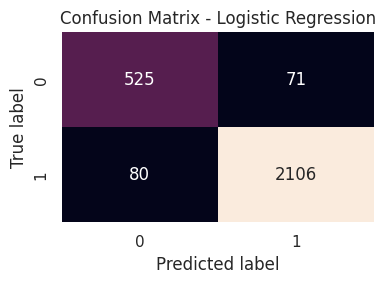


=== k-NN ===
Classification report:
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       596
         1.0       0.98      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.91      0.94      0.92      2782
weighted avg       0.95      0.95      0.95      2782

ROC-AUC: 0.9690065517601332


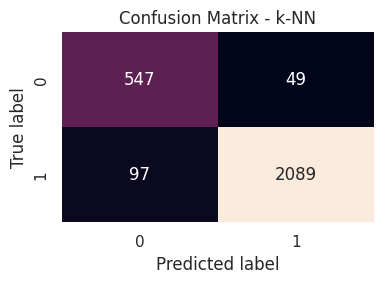


=== Decision Tree ===
Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       596
         1.0       0.98      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.95      0.93      2782
weighted avg       0.96      0.95      0.95      2782

ROC-AUC: 0.9707903252546712


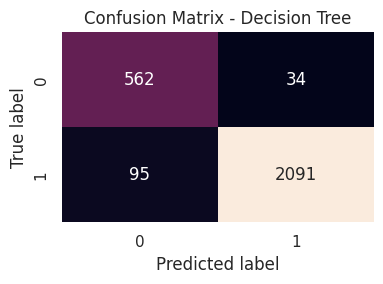


=== Random Forest ===
Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89       596
         1.0       0.98      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.95      0.93      2782
weighted avg       0.96      0.95      0.95      2782

ROC-AUC: 0.9802652787414726


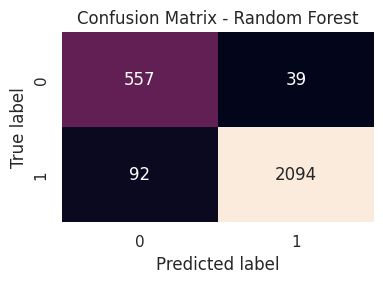

In [ ]:

# 2.7 Preliminary validation plan

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


feature_names = X.columns.tolist()

# 1) Confusion matrices + basic metrics for each model
for name, model in trained_models.items():
    # Choose scaled unscaled data depending on model
    if "k-NN" in name or "Logistic" in name:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test

    y_pred = model.predict(X_test_input)

    # If model supports predict_proba then compute ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_input)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc_auc = None

    print(f"\n=== {name} ===")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    if roc_auc is not None:
        print("ROC-AUC:", roc_auc)

    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


# 2) Feature importance / coefficients for interpretable models

# (a) Logistic Regression coefficients
if "Logistic Regression" in models:
    log_reg = models["Logistic Regression"]
    if hasattr(log_reg, "coef_"):
        coefs = log_reg.coef_[0]
        coef_series = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)

        plt.figure(figsize=(6, 4))
        coef_series.head(10).plot(kind="bar")
        plt.title("Top 10 Logistic Regression Coefficients")
        plt.ylabel("Coefficient value")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# (b) Decision Tree feature importances
if "Decision Tree" in models:
    dt = models["Decision Tree"]
    if hasattr(dt, "feature_importances_"):
        dt_imp = pd.Series(dt.feature_importances_, index=feature_names).sort_values(ascending=False)

        plt.figure(figsize=(6, 4))
        dt_imp.head(10).plot(kind="bar")
        plt.title("Top 10 Feature Importances - Decision Tree")
        plt.ylabel("Importance")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# (c) Random Forest feature importances
if "Random Forest (Advanced)" in models:
    rf = models["Random Forest (Advanced)"]
    if hasattr(rf, "feature_importances_"):
        rf_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

        plt.figure(figsize=(6, 4))
        rf_imp.head(10).plot(kind="bar")
        plt.title("Top 10 Feature Importances - Random Forest")
        plt.ylabel("Importance")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


In [ ]:
#2.8 Future Work

from sklearn.ensemble import VotingClassifier

# 1) Example: Add temporal features (seasonality) at the inspection level


df['year'] = df['Inspection Date'].dt.year
df['month'] = df['Inspection Date'].dt.month

# Simple "season" feature (1-4)
def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df['season'] = df['month'].apply(month_to_season)

print("Example temporal columns added to df: 'year', 'month', 'season'")
print(df[['Name', 'Inspection Date', 'year', 'month', 'season']].head())


# 2) Example: Hybrid / ensemble model combining Logistic Regression and Random Forest
# (soft voting to balance interpretability and flexibility)

# Reuse scaled vs unscaled approach:
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

# For simplicity, fit on scaled features
voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_model),
        ("rf", rf_model)
    ],
    voting="soft"
)

voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
y_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]

print("\n=== Voting Classifier (LogReg + RF) ===")
print("Classification report:")
print(classification_report(y_test, y_pred_voting))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_voting))


# 3) "Dashboard-style" risk view
#    Show restaurants ranked by predicted riskusing Random Forest or VotingClassifier)


risk_model = models.get("Random Forest (Advanced)", rf_model)

# Fit on the full dataset
risk_model.fit(X, y)
risk_proba = risk_model.predict_proba(X)[:, 1]

risk_table = pd.DataFrame({
    "Name": features["Name"],
    "predicted_red_violation_risk": risk_proba
})

# Top 10 highest-risk restaurants
top_risk = risk_table.sort_values("predicted_red_violation_risk", ascending=False).head(10)
print("\nTop 10 restaurants by predicted red violation risk:")
print(top_risk)


Example temporal columns added to df: 'year', 'month', 'season'
                Name Inspection Date  year  month  season
13  #807 TUTTA BELLA      2021-01-06  2021      1  Winter
12  #807 TUTTA BELLA      2022-01-13  2022      1  Winter
10  #807 TUTTA BELLA      2022-08-31  2022      8  Summer
11  #807 TUTTA BELLA      2022-08-31  2022      8  Summer
8   #807 TUTTA BELLA      2023-03-02  2023      3  Spring

=== Voting Classifier (LogReg + RF) ===
Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       596
         1.0       0.98      0.96      0.97      2186

    accuracy                           0.95      2782
   macro avg       0.92      0.94      0.93      2782
weighted avg       0.95      0.95      0.95      2782

ROC-AUC: 0.9791673062871108

Top 10 restaurants by predicted red violation risk:
                           Name  predicted_red_violation_risk
4                   100 LB CLAM                       